# Kr Fits

J. A Hernando, C. Herves

April 2022

In [133]:
%matplotlib inline 

#%matplotlib notebook
#matplotlib widget
%reload_ext autoreload
%autoreload 2

In [134]:
import numpy             as np
import pandas            as pd
import tables            as tb
from   scipy             import stats
from   scipy             import optimize

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

plt.rcParams['image.cmap'] = 'rainbow'

In [135]:
import hipy.utils        as ut
import hipy.pltext       as pltext
import hipy.profile      as prof

#import nana.bclouds.bclouds      as bc
#import hipy.hfit         as hfit

#import invisible_cities.io.dst_io as dio

In [136]:
pltext.style()

import warnings
warnings.filterwarnings('ignore')

import time
print(' Last revision ', time.asctime())

 Last revision  Wed May  4 09:22:46 2022


In [137]:
#import os
import re
import glob

from collections import namedtuple

## Code

In [138]:
size             = 100
e0, tau0, length = 41.5, 10, 1.
wi               = 41.5/2000.

def generate_toy(size, e0 = e0, tau0 = tau0, length = length, sigma_ref = 0.04):
    
    ts = length * stats.uniform.rvs(size = size)
    es  = e0 * ((1 - ts/tau0) + sigma_ref * stats.norm.rvs(size = size))
    return ts, es

@np.vectorize
def attachment(t, lifetime, n_ie):
    return np.count_nonzero(-lifetime * np.log(np.random.uniform(size=int(n_ie))) > t)

def generate_toy_att(size = size, e0 = e0, tau0 = tau0, length = length, wi = wi):
    nie0     = e0/wi
    tis      = length * stats.uniform.rvs(size = size)
    nies     = stats.poisson.rvs(nie0, size = size)
    nis      = attachment(tis, tau0, nies)
    eis      = e0 * nis/nie0
    return tis, eis

def generate_toy_bin(size = size, e0 = e0, tau0 = tau0, length = length, wi = wi):
    nie0     = e0/wi
    tis      = length * stats.uniform.rvs(size = size)
    nies     = stats.poisson.rvs(nie0, size = size)
    ps       = 1 - tis/tau0
    nks      = stats.binom.rvs(nies, ps) * wi 
    return tis, nks

In [139]:
st_ipar = lambda t, a, b : a - b * t
st_cpar = lambda t, a, b : a * (1 - t / b) 

def chisq(fun, ts, es, pars): 
    res = (es - fun(ts, *pars)) 
    sig = np.sum(res * res)
    return sig

def experiments(generate, fun, e0 = e0, tau0 = tau0, mexps = 1000, size = 100):
    rs    = []
    for i in range(mexps):
        ts, es = generate(size = size, e0 = e0, tau0 = tau0)
        r      = optimize.curve_fit(fun, ts, es)
        #chi2   = chisq(fun, ts, es, r[0])
        rs.append((r[0], r[1])) 
    return rs

def plot_res(res, a0, b0, alabel = '', blabel = ''):
    
    alphas  = np.array([r[0][0] for r in res])
    betas   = np.array([r[0][1] for r in res])
    ualphas = np.array([np.sqrt(np.diag(r[1]))[0] for r in res])
    ubetas  = np.array([np.sqrt(np.diag(r[1]))[1] for r in res])
    cov     = np.array([r[1][0, 1]                for r in res])
    #chi2    = np.array([r[2] for r in res])

    canvas = pltext.canvas(8, 3)
    canvas(1)
    pltext.hist(alphas, 100);
    plt.xlabel(alabel);
    canvas(2)
    pltext.hist(ualphas, 100);
    plt.xlabel(alabel + ' uncertainty');
    canvas(3)
    pltext.hist((alphas - a0)/ualphas, 100);
    plt.xlabel(alabel + ' pool');

    canvas(4)
    pltext.hist(betas, 100);
    plt.xlabel(blabel);
    canvas(5)
    pltext.hist(ubetas, 100);
    plt.xlabel(blabel + ' uncertainty');
    canvas(6)
    pltext.hist((betas - b0)/ubetas, 100);
    plt.xlabel(blabel + ' pool');

    canvas(7)
    plt.hist2d(alphas, betas, (20, 20));
    plt.xlabel(alabel); plt.ylabel(blabel); plt.colorbar();
    canvas(8)
    pltext.hist(cov, 100);
    plt.xlabel('cov')
    
    plt.tight_layout()
    return

## Simple Generator

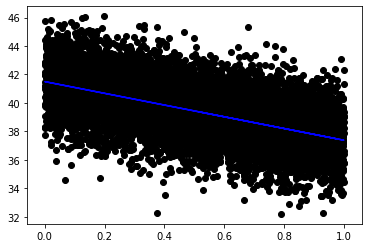

In [140]:
ts, es   = generate_toy(size = 100 * size)
par, cov = optimize.curve_fit(st_ipar, ts, es)
plt.scatter(ts, es);
plt.plot(ts, st_ipar(ts, *par), c = 'blue');

In [141]:
def residuals_(ts, es, par, cov):
    
    xv    = np.ones(shape = (2, len(ts)))
    xv[1] = -ts
    res   = np.dot(par, xv) - es

    var   = np.sum(xv * np.matmul(cov, xv), axis = 0)
    sig   = np.sqrt(var)
    
    sigma = np.sqrt(np.sum(res * res)/ (len(ts) - 2))
    return res, sig, sigma 

In [142]:
res, sig, sigma = residuals_(ts, es, par, cov)

In [143]:
chi2  = np.sum(res*res)
sigma = np.sqrt(np.sum(res*res)/(len(res)-2))
print(sigma)

1.653543619512703


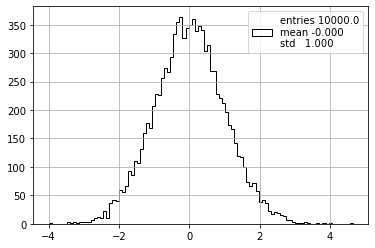

In [144]:
pltext.hist(res/sigma, 100);

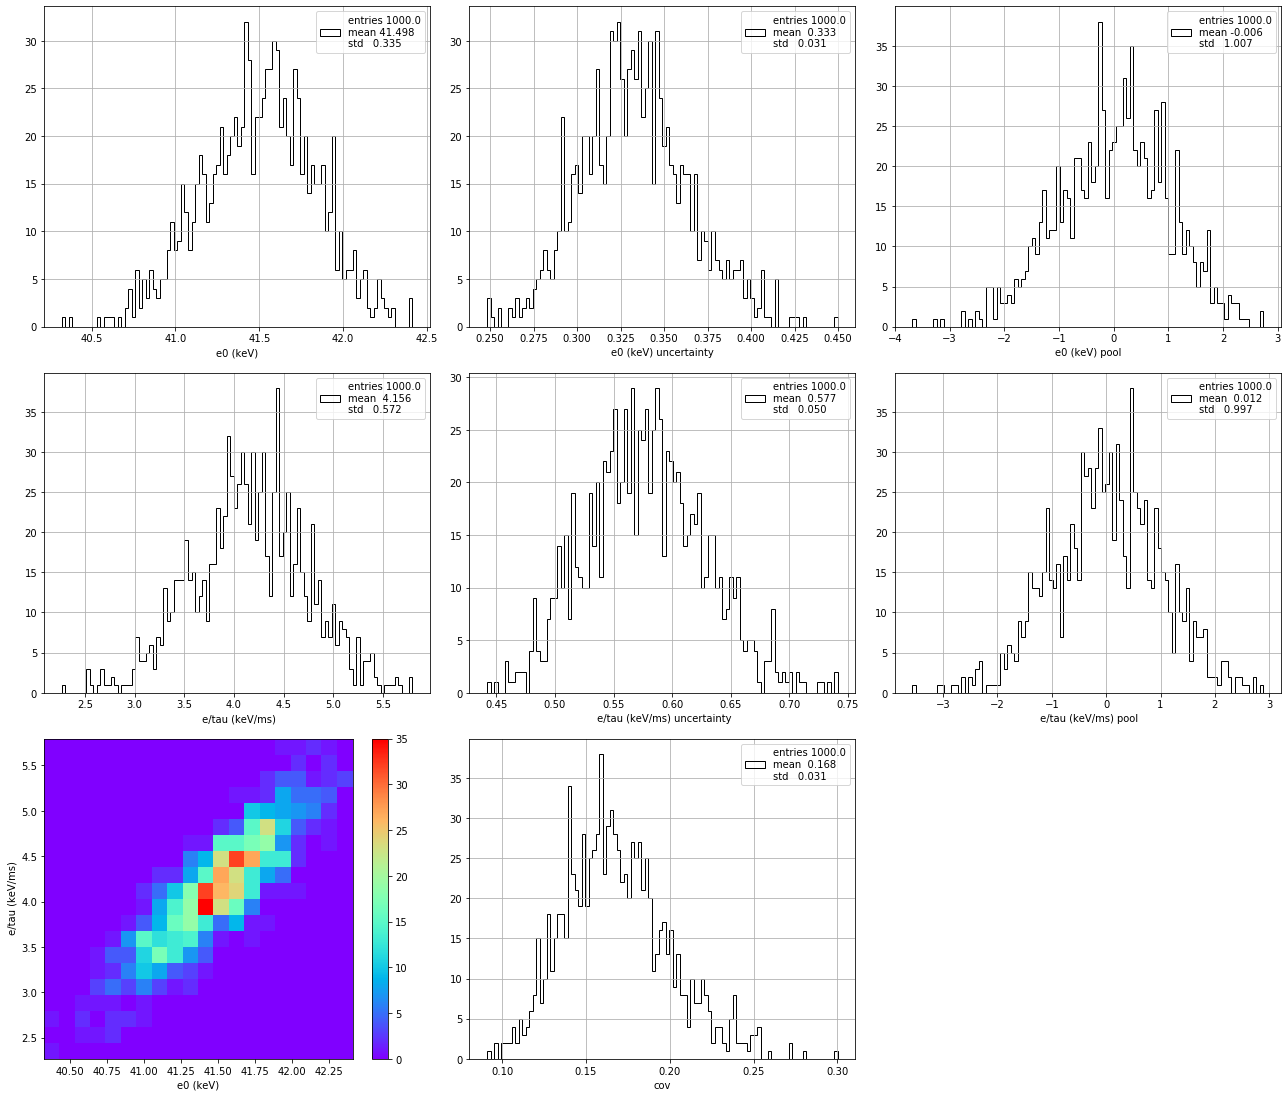

In [145]:
rs = experiments(generate_toy, st_ipar)
plot_res(rs, e0, e0/tau0, 'e0 (keV)', ' e/tau (keV/ms)')

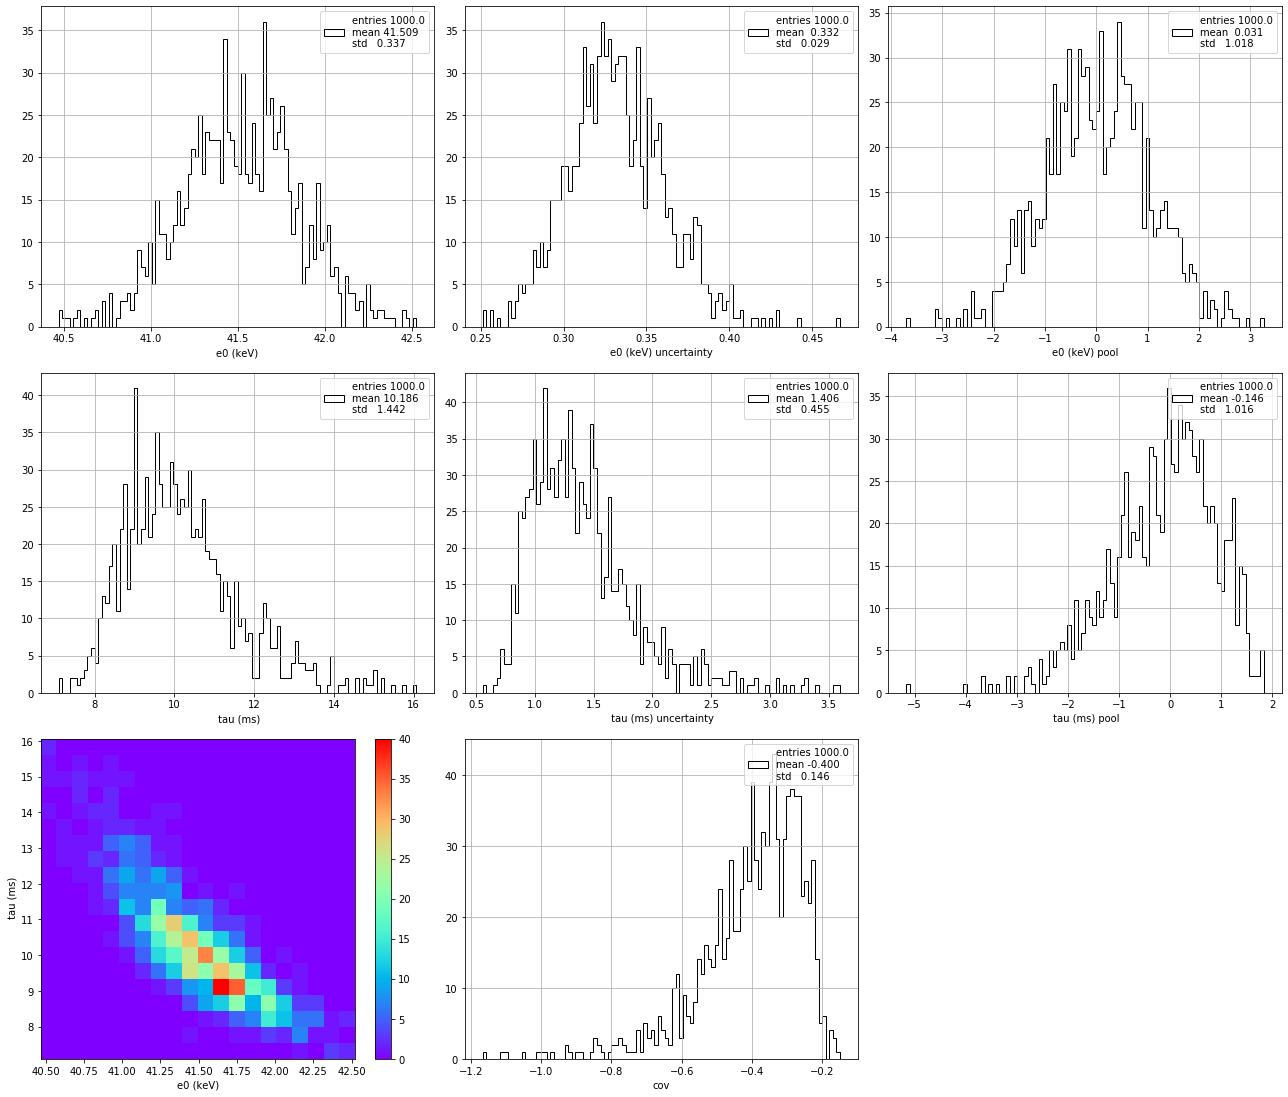

In [146]:
rs = experiments(generate_toy, st_cpar)
plot_res(rs, e0, tau0, 'e0 (keV)', ' tau (ms)')

## Attachment generator

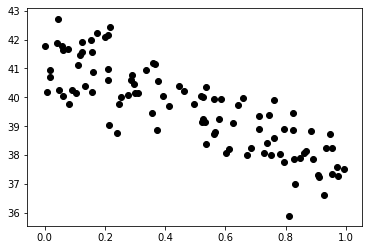

In [147]:
ts, es = generate_toy_att(size = size)
plt.scatter(ts, es);

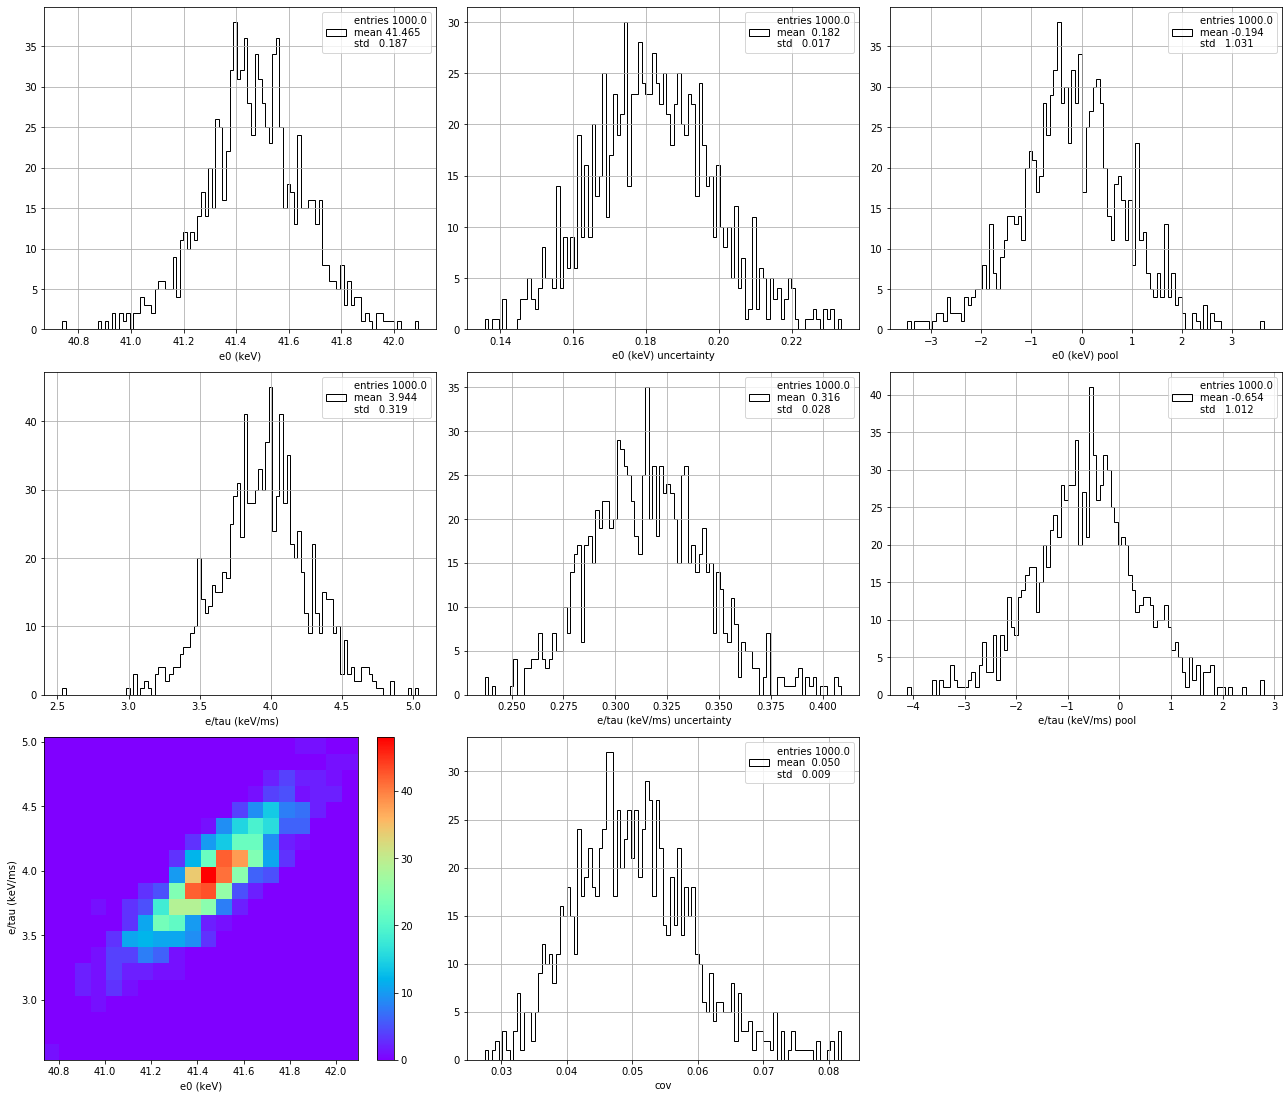

In [148]:
rs = experiments(generate_toy_att, st_ipar)
plot_res(rs, e0, e0/tau0, 'e0 (keV)', ' e/tau (keV/ms)')

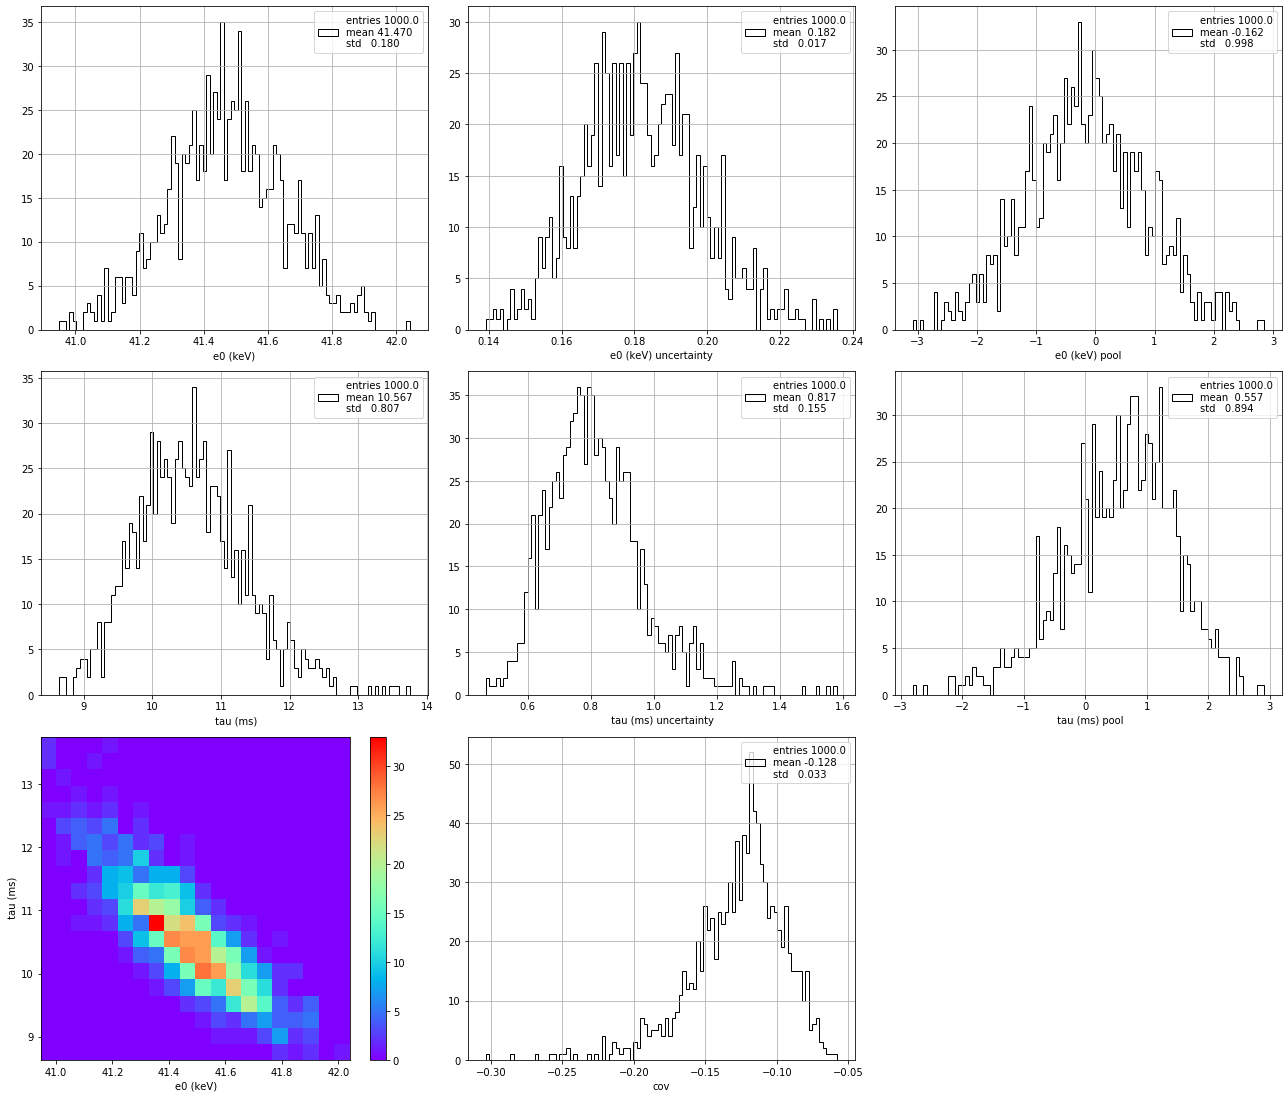

In [149]:
rs = experiments(generate_toy_att, st_cpar)
plot_res(rs, e0, tau0, 'e0 (keV)', ' tau (ms)')

## Binomial generator

(array([41.16672767,  3.52404483]), array([[0.03768224, 0.05545364],
       [0.05545364, 0.10980565]]))


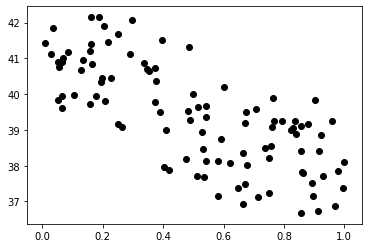

In [150]:
ts, es = generate_toy_bin(size = size)
res    = optimize.curve_fit(st_ipar, ts, es)
print(res)
plt.scatter(ts, es);

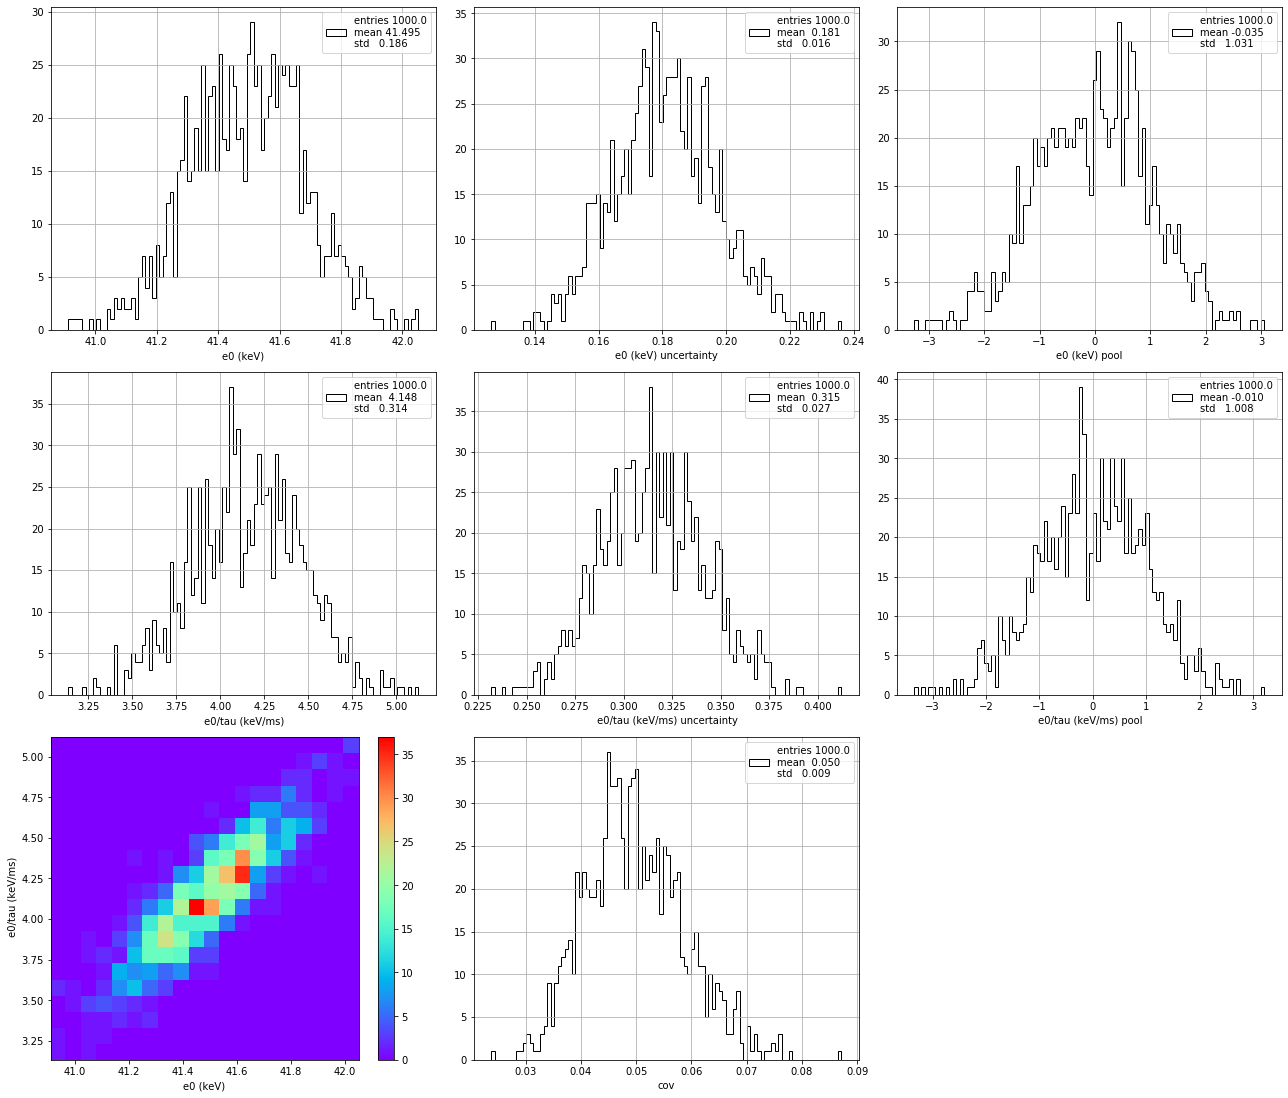

In [151]:
rs = experiments(generate_toy_bin, st_ipar)
plot_res(rs, e0, e0/tau0, 'e0 (keV)', ' e0/tau (keV/ms)')

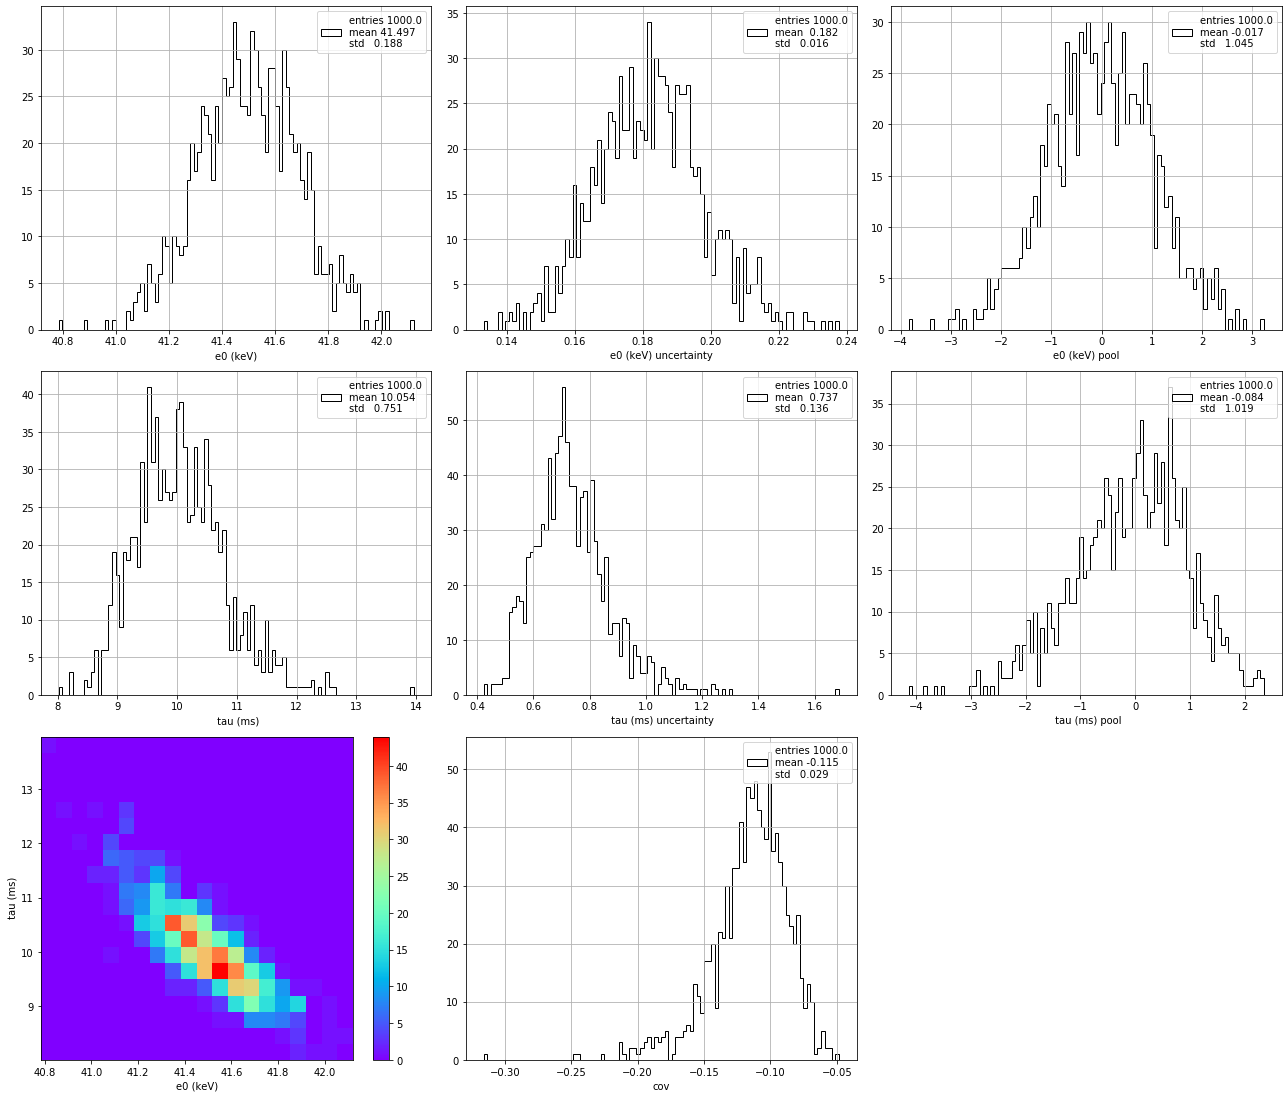

In [152]:
rs = experiments(generate_toy_bin, st_cpar)
plot_res(rs, e0, tau0, 'e0 (keV)', ' tau (ms)')

## Fit at the center of the chamber

In [153]:
st_imed = lambda t, a, b : a - b * ( t - length/2)

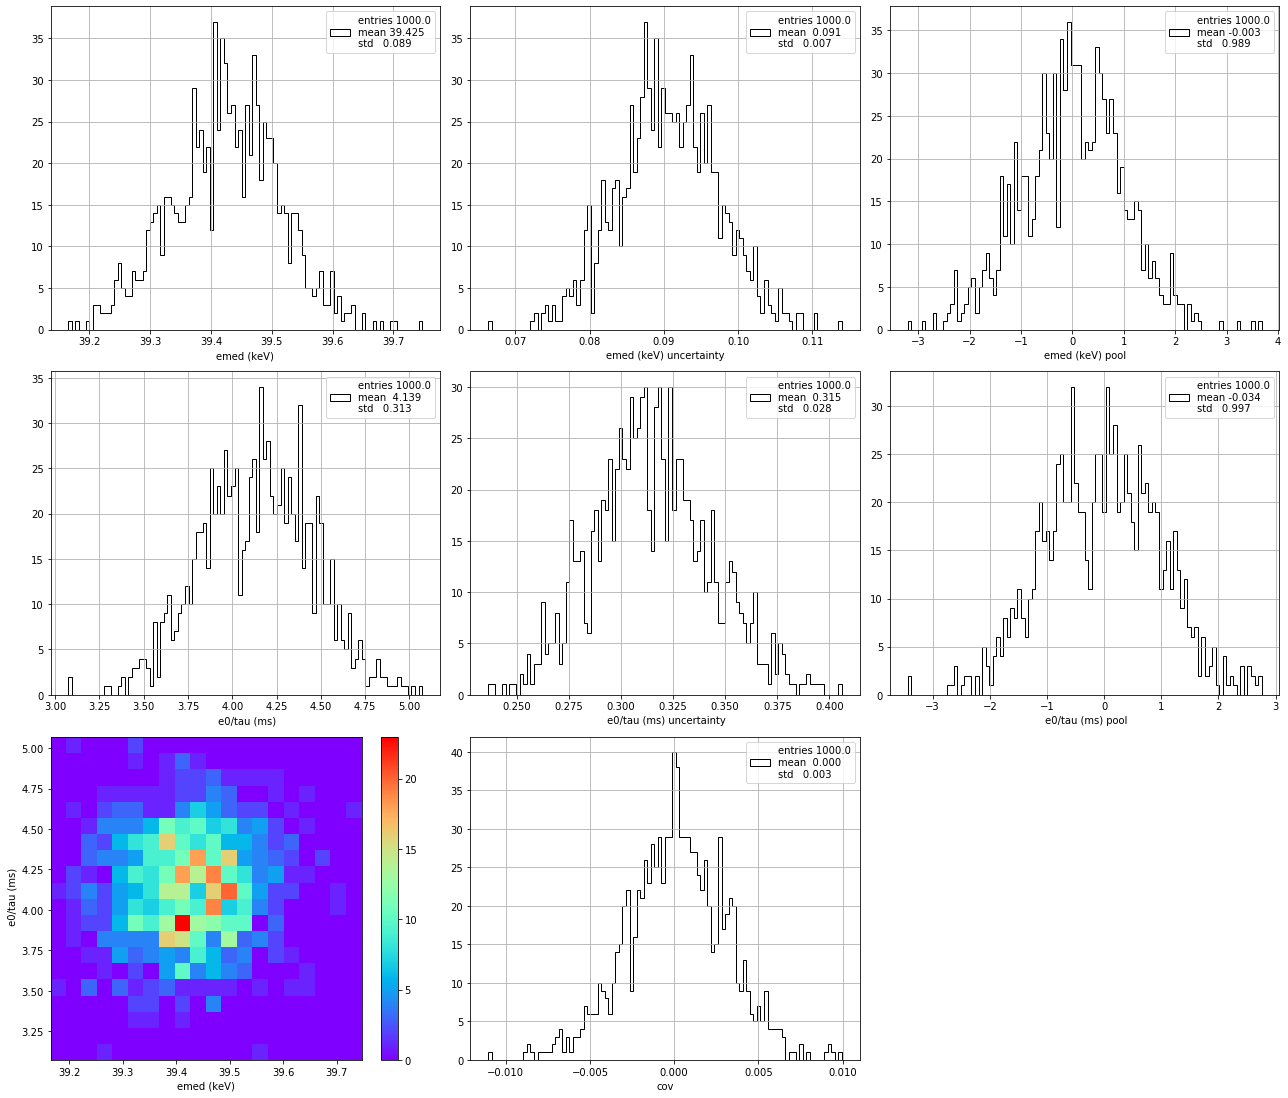

In [154]:
e0_med = e0 * (1- length/(2 * tau0))
rs = experiments(generate_toy_bin, st_imed)
plot_res(rs, e0_med, e0/tau0, 'emed (keV)', ' e0/tau (ms)')

## Test Decorrelate